In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
from pylab import *
import seaborn as sns
sns.set_style("white")
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import backend.gotstools as gt
import src.test_EcgBeatDetector.wfdbtools as wfdb
from scipy.io import loadmat

# Introduction

## An initial overview of synthatic search on time series

The Synthatic Search on Time Series (SSTS) approach uses three steps that traduce a given time series into a set of primitives, in which the rules of regular expressions can be applied. This methodology presents several advantages over traditional methods and simplifies query problems on time series.

SSTS is divided into three modules: (1) Pre-processing, (2) Symbolic Connotation and (3) Search:

<img src="imgs/ssts_overview.png">

First, the user is able to perform pre-processing operations over time series using a pipeline of tokens that represents methods. Secondly, a set of connotation tokens is also used to customize the symbolic connotation. Finnaly, a search string is supplied in order to perform a query over the time series using the rules of regular expressions.

## SSTS main method

In order to perform a search, the user should call the SSTS main method: ```ssts(s, cfg)```. The ```s``` parameter represents the time series and should be a list or a ndarray. The ```cfg``` is a dictionary that contains a full description of the customization for each step.

The method returns an array of ```matches```, that correspond to the intervals at which positive matches were found using the search string.

# Examples
## 1. Start and end of plateau
* **Signal type**: Z-axis of accelerometer data;
* **Description**: The accelerometer sensor was positioned on the wrist. The data has been acquired with a sampling frequency of 1000 Hz, while the subject performed multiple levels of rotation of the wrist (45, 60 and 90 degrees). In each orientation, the subject has sustained the position for a 245 couple of seconds;
* **Problem**: Detect the beginning and ending of a plateau that corresponds to a rotation above 60 degrees.

In [2]:
s = np.loadtxt('./data/StartEndPlateau/plateau10.txt')[:, 4]

### 1.1. Search for the start of plateau

[(2557, 2559), (8962, 8964), (19804, 19806), (28347, 28349), (31097, 31099)]


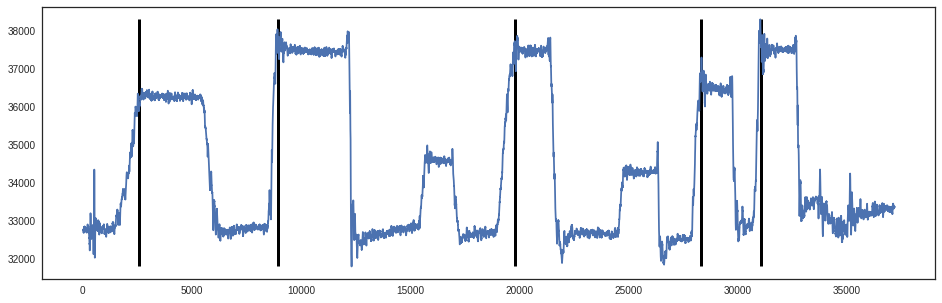

In [3]:
cfg = {
  "pre_processing": "~ 500",
  "connotation": "⇞ 0.82 † 0.05",
  "expression": "\+1_"
}

matches = gt.ssts(s, cfg)
print(matches)
gt.plot_matches(s, matches)

### 1.2. Search for the end of plateau

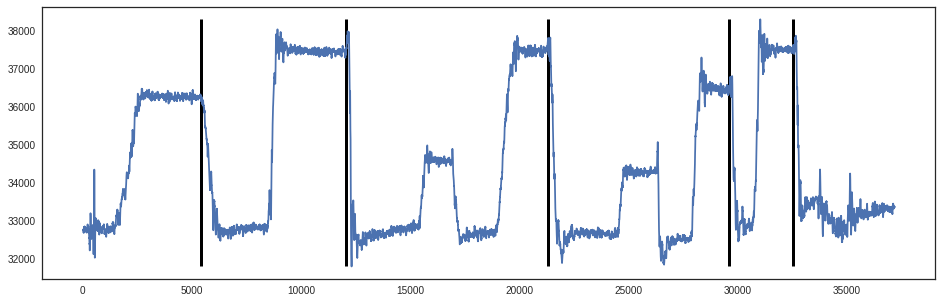

In [4]:
cfg = {
  "pre_processing": "~ 500",
  "connotation": "⇞ 0.82 † 0.05",
  "expression": "_1-"
}

matches = gt.ssts(s, cfg)
gt.plot_matches(s, matches)

## 2. Step detection
* **Signal type**: Magnitude of accelerometer data;
* **Description**: Data collected from a sensor located on the right pocket of a subject while performing sets of straight normal walk at 100 Hz;
* **Problem**: Detect the instants in time when a right or left heel floor contact is achieved during normal straight walk. This information can be used to create a step detector based on accelerometer data. Since the sensor is located on the right pocket, global minima will indicate the right heel contact and local minima will correspond to left heel contact.

In [5]:
vm = np.array(pd.read_csv('./data/StepDetection/test2/Accelerometer.txt', header=None))
t, m = vm[:, 0], vm[:, 1:-1]
s = gt.vmagnitude(m)[200:1400]

### 2.1. Left Heel

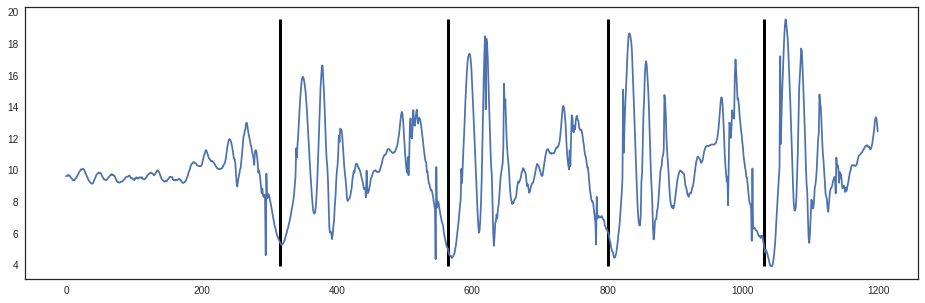

In [6]:
cfg = {
  "pre_processing": "☴ 2 2 100 ~ 50",
  "connotation": "⇞ 0.4 † 0.05",
  "expression": "0_0\+"
}

matches = gt.ssts(s, cfg)
gt.plot_matches(s, matches)

### 2.2. Right Heel

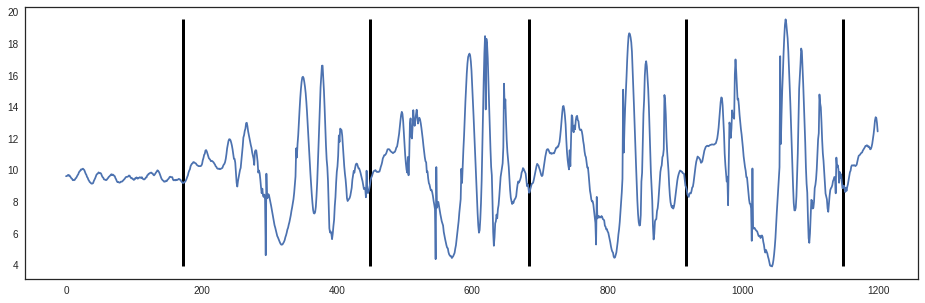

In [7]:
cfg = {
  "pre_processing": "☴ 2 2 100 ~ 50",
  "connotation": "⇞ 0.4 † 0.05",
  "expression": "1_1\+"
}

matches = gt.ssts(s, cfg)
gt.plot_matches(s, matches)

## 3. Systholic phase segmentation

* **Signal type**: Continuous ABP data;
* **Description**: This data was downloaded from the MIMIC-IIWaveform's Physiobank ATM database. It was collected from bedside patient monitors in adult and neonatal intensive care units (ICUs), 260 at 125 Hz. Multiple waveforms were acquired simultaneously, such as ECG, ABP and respiratory 
* **Problem**: The dicrotic notch corresponds to the physiological event of the aortical valve closure, which triggers the increase of the aortic pressure and signifies the end of the systolic phase. In this problem, it is asked to segment the systolic phase of the ABP wave.

In [8]:
s = loadmat('./data/BVP/3500015m_2.mat')['val'][0][205000:206000]

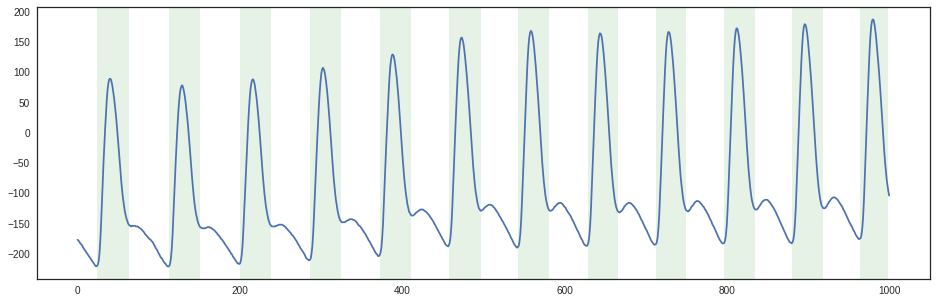

In [9]:
cfg = {
 "pre_processing": "☲ 1 20 2 125",
 "connotation": "↕ 0.6 † 0.01",
 "expression": "(1\+).+?0"
}

matches = gt.ssts(s, cfg)
figure(figsize=(16, 5)); plot(s); [axvspan(i[0], i[1], facecolor='green', alpha=0.10) for i in matches];

## 4. Electrocardiogram peak detector
* **Signal Type**: Electrocardiogram signal;
* **Description**: This data has been downloaded from the MIT-BIH Arrhythmia Database found at the Physiobank ATM. The source of the ECGs included in this database is a set of over 4000 long-term Holter recordings that were obtained by the Beth Israel Hospital Arrhythmia Laboratory between 1975 and 1979. The Database contains two main sets, one with 23 records chosen at random from this set, and the other with 25 records that include a variety of rare but clinically important phenomena. The recording were digitized at 360 samples per second per channel with 11-bit resolution over a 10 mV range.
* **Problem**: Detect all the major peaks from the record.

In [10]:
seq_data, seq_info = wfdb.rdsamp('./data/EcgBeatDetection/100', start=0, end=10)
t, s = seq_data[:, 1], seq_data[:, 2]

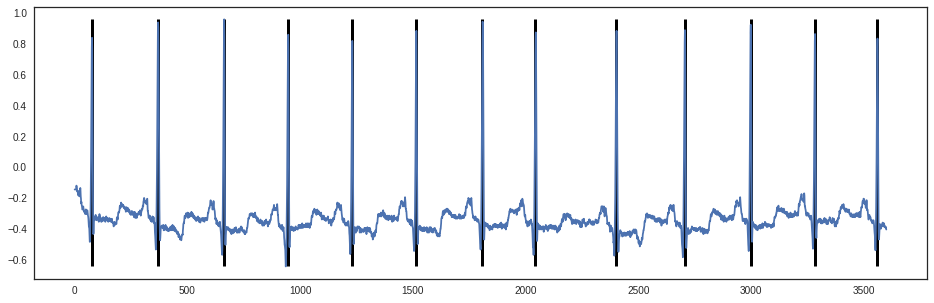

In [11]:
cfg = {
  "pre_processing": "☲ 5 50 2 360",
  "connotation": "† 0.01",
  "expression": "\+-"
}
matches = gt.ssts(s, cfg, report='clean')
gt.plot_matches(s, matches, scatter=True)

## 5. Straight line trajectory tracking
* **Signal type**: A vector of cartesian coordinates in two dimensional space;
* **Description**: This data was generated to simulate a spatial trajectory of a Human subject inside a building environment. Indoor navigation systems rely on a set of sensors that are able to convert contextual and physical information into the subject's absolute location inside a building;
* **Problem**: The automatic detection of features, such straight walks and turns can be used to look for trajectory anomalies.

In [12]:
mapxy = np.array(pd.read_csv('./data/TrajectoryTracking/coord_demo3.txt', header=None))
x, y = gt.smooth(mapxy[:, 0], 50), gt.smooth(mapxy[:, 1], 50)

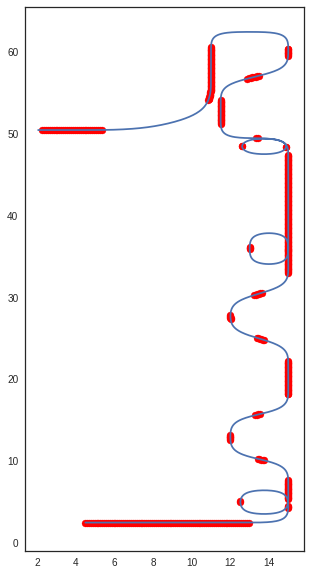

In [13]:
cfg = {
  "pre_processing": "",
  "connotation": "‡ 0.05",
  "expression": "_*?"
}
matches = gt.ssts([x, y], cfg, report='clean')

figure(figsize=(5, 10))
plot(x, y)
[scatter(x[arange(m[0], m[1])], y[arange(m[0], m[1])], color='r') for m in matches];

## 6. Stable Lifting Step Detection
* **Signal type**: Accelerometer data;
* **Description** : The accelerometer was positioned on the wrist while the subject performed a repetition of a weight lifting exercise (biceps curl) during 10 seconds. The data has been acquired at 1000 Hz.
* **Problem**: Since the first 5 seconds of the lifting exercise are unstable, the problem involves detecting the first stable lifting step, which occurs approximately 5 seconds after the beginning of the exercise.

In [14]:
acc = np.loadtxt('./data/StableLiftingStepDetection/test4.txt')[:10000,2:5]
acc[:,0] = (((acc[:,0]-28000)/(38000-28000))*2)-1
acc[:,1] = (((acc[:,1]-28000)/(38000-28000))*2)-1
acc[:,2] = (((acc[:,2]-28000)/(38000-28000))*2)-1
s = gt.vmagnitude(acc)

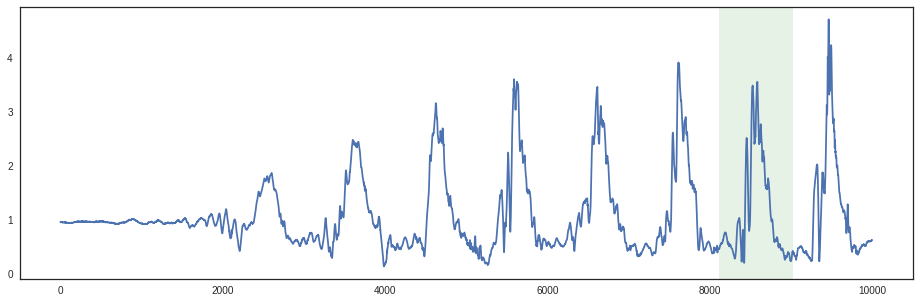

In [15]:
cfg = {
  "pre_processing": "⊚ ∥ ~ 1000 | ⊚ ~ 750",
  "connotation": "⇞ 0.1 | † 0.01 ['-','+','+']",
  "expression": "(?<=1.{10000,})(-.\+)(.+?)(-.\+)"
}

matches = gt.ssts(np.array([s, s]), cfg)
figure(figsize=(16, 5)); plot(s);axvspan(matches[0][0], matches[0][1], facecolor='green', alpha=0.10);